# Analysis Overview

This notebook includes a general overview of the dataset by (1) preparing your workspace to use the dataset in the COCO format, (2) visualizing a few images from one of the datasets for information purposes, and (3) conducting an analysis on modifications made to the Faster R-CNN model.  The dataset used is the SARscope dataset found at the below link.  The objective of this project is to determine whether proposed image processing methods would increase the performance of different models on Synthetic Aperture Radar data of maritime vessels.

Dataset: https://www.kaggle.com/datasets/kailaspsudheer/sarscope-unveiling-the-maritime-landscape

## Section 1 - Workspace Preparation

To ensure that the user can run this notebook without issue, please do the following:

1. Ensure your Python installtion is 3.8.10 or higher.
2. You are using the pip3 package manager.
3. Run the below installation steps. These are all the packages used in this notebook.

In [1]:
# %pip3 install torch
# %pip3 install torchvision
# %pip3 install torchmetrics
# %pip3 install kagglehub
# %pip3 install json
# %pip3 install matplotlib
# %pip3 install cv2
# %pip install pycocotools
# %pip install utils

In [2]:
# Utility Imports
import os, sys
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Data Handling Imports
from SeaSarFRCNN import SeaSarFRCNN
from ModelWorker import ModelWorkerFRCNN
from WorkspaceManager import WorkspaceManager

# Model and Model Utility Imports
import torchvision
import torch
from frcnn_models import CannyFRCNN, RobinsonFRCNN, RobinsonCompass

project_path = pathlib.Path.cwd().parent.resolve()
print(f"Project path: {project_path}")

Project path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR


/home/jag1799/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Section 2 - Dataset Loading

### Section 2.1: Note on Kagglehub

Kagglehub does not natively support downloading to specific directories on the user's file system.  It instead downloads it to a cache folder, which may vary between users.  Thus, the below script moves all downloads will move the dataset folder to the included */data* folder in this repo.

If you have an error, this is likely due to the `shutil.move()` command failing because it sees the dataset still cached.  To counteract this, `cd` into the cache directory that is printed in the output and delete the entire data folder.  Then run this block again.  See Section 2.2 and the below code block comments for additional information.

### Section 2.2: Deleting the Cache

To re-download the dataset, you need to remove both the formatted folder in this repo's data directory (the *kaggle* folder) and the *kailaspsudheer* folder in the cache.

I recommend you run the *WorkspaceManager* setup block below with *clear_cache* off first, then manually delete it if you need to.  After you know where your cache is and confirm it's deleting the right directory, you can turn it on.

In [3]:
workspace_builder = WorkspaceManager()
workspace_builder.run_setup()

if not os.path.exists(workspace_builder._data_path):
    raise FileNotFoundError(f"Not able to find data directory at path: {workspace_builder._data_path}")
else:
    print(f"Using data path: {workspace_builder._data_path}")

Project path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR
Found existing data path at /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle
Using data path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle/SARscope


## Section 3 - Data Visualization

Below, we visualize a few randomly selected images throughout the validation dataset as examples of the different types of images the models will encounter and to ensure the annotations are working as expected.  All targets have the same category Id and category name: (1, "ship").

In [4]:
# Validation Path retrieval
tester_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_annotations = os.path.join(workspace_builder._data_path, "annotations", "train_annotations.coco.json")
train_images = os.path.join(workspace_builder._data_path, "train")

train_data = SeaSarFRCNN(train_images, train_annotations, tester_transforms)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


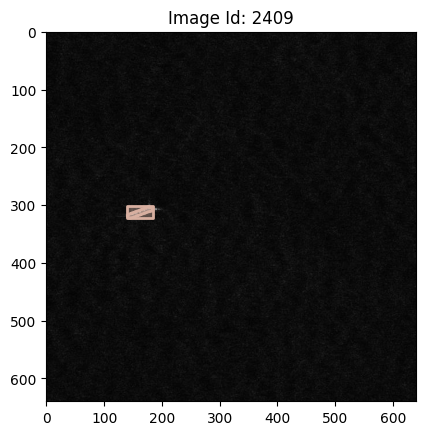

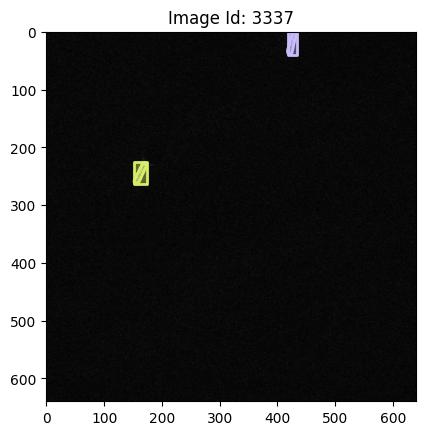

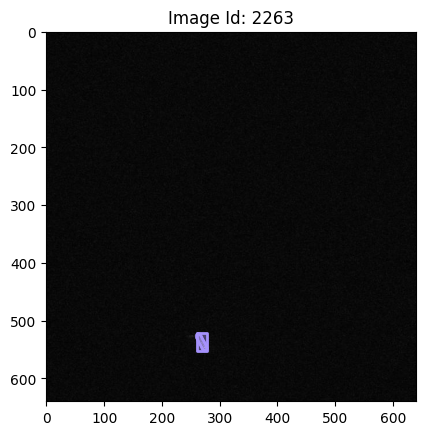

In [5]:
# Display 3 randomly selected images throughout the validation dataset with their annotations.
for i in range(3):
    train_data._random_image()
    plt.show()

## Section 4 - Faster R-CNN

This section begins the analysis of different layer additions and modifications to the Faster R-CNN model.  Each section contains the following sub-sections for reference:

1. Data Preparation
2. Model Construction
3. Training
4. Testing & Analysis

### Section 4.1 - Baseline FRCNN

This section is to establish the baseline performance of an unmodified FRCNN model on our dataset.

#### Section 4.1.1 - Data Preparation

In [6]:
# Set up train dataloader
train_data = torchvision.datasets.wrap_dataset_for_transforms_v2(train_data, target_keys=("boxes", "labels"))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True, collate_fn=train_data._packager)

In [7]:
validation_annotations = os.path.join(workspace_builder._data_path, "annotations", "valid_annotations.coco.json")
validation_images = os.path.join(workspace_builder._data_path, "valid")
validation_data = SeaSarFRCNN(validation_images, validation_annotations, transform=tester_transforms)
validation_data = torchvision.datasets.wrap_dataset_for_transforms_v2(validation_data, target_keys=("boxes", "labels"))
validation_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=1, shuffle=False, collate_fn=validation_data._packager)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


#### Section 4.1.2 - Model Setup

In [8]:
# Build the baseline model
frcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
input_features = frcnn.roi_heads.box_predictor.cls_score.in_features
frcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features, 2)

# Build the loss function and optimizer
optimizer = torch.optim.Adam(frcnn.parameters(), lr=0.001)

/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Section 4.1.3 - Baseline Training & Validation

When running training, be advised that you may need to close other programs, completely kill your Jupyter Kernel, or restart VSCode.  FRCNN and Pytorch consume significant amounts of memory per run and remain allocated in the background on your GPU.  After enough times running train/validation cells, the program will fail saying CUDA is out of memory.  This is when you must either manually kill background programs from the terminal or restart VSCode.  Below are the instructions to determine which programs to kill.

**NOTE**: These instructions were written for Ubuntu Linux 20.04.  Your steps may differ slightly.

1. Open a terminal window
2. Assuming you have CUDA set up, enter the "*nvidia-smi*" command.  This will display all processes currently using your GPU.
3. Run *sudo fuser -v /dev/nvidia\**.  This will display another list of process also using your GPU, including the owner of said process.
    - This step is to differentiate between your processes and system processes.  
    - **DO NOT EVER KILL A SYSTEM PROCESS USING THESE STEPS. IF IT IS CAUSING PROBLEMS, RESTART YOUR COMPUTER AND THIS CAN SAFELY REFRESH ALL PROCESSES USING YOUR GPU.**
4. Identify all processes owned by you and get their PIDs.
5. Refer back to the *nvidia-smi* table on which PID is consuming the most memory.
6. Do one of the following:
    - If possible, close the process normally like a Firefox window.
    - Run *sudo kill -9 "your_PID"*.

In [ ]:
# Do training and validation
worker = ModelWorkerFRCNN(optimizer=optimizer, frcnn=frcnn, quiet=False)
worker.train(train_dataloader, 5, [3736])

Batch: 49/4716 | Batch Loss: 0.41231554746627814

############# Epoch: 0 Complete #############
Total Epoch Combined Loss: 66.69910683482885
Loss Objectness: 45.70431409776211
RPN Region Proposal Losses: 8.768950461875647
Classifier Loss: 8.7872542636469
Bounding Box Region Loss: 3.4385882483329624


Batch: 49/4716 | Batch Loss: 0.45894223451614388

############# Epoch: 1 Complete #############
Total Epoch Combined Loss: 18.902226645499468
Loss Objectness: 9.54421703144908
RPN Region Proposal Losses: 3.888797333347611
Classifier Loss: 3.372766988351941
Bounding Box Region Loss: 2.0964455291978084




In [10]:
# Run validation
worker.validation(validation_dataloader, 2, [50])

Batch: 49/1346 | Batch Loss: 2.14871954917907734

############# Epoch: 0 Complete #############
	Total Epoch Loss: 20.49395751953125
	Loss Objectness: [5.318451575934887]
	RPN Region Proposal Losses: 3.6343769589730073
	Classifier Loss: 5.666195139288902
	Bounding Box Region Loss: 5.874931464670226
Batch: 49/1346 | Batch Loss: 2.12583875656127932

############# Epoch: 1 Complete #############
	Total Epoch Loss: 20.561857223510742
	Loss Objectness: [5.318451575934887, 5.438351657241583]
	RPN Region Proposal Losses: 3.5919136563607026
	Classifier Loss: 5.656662043184042
	Bounding Box Region Loss: 5.874931464670226


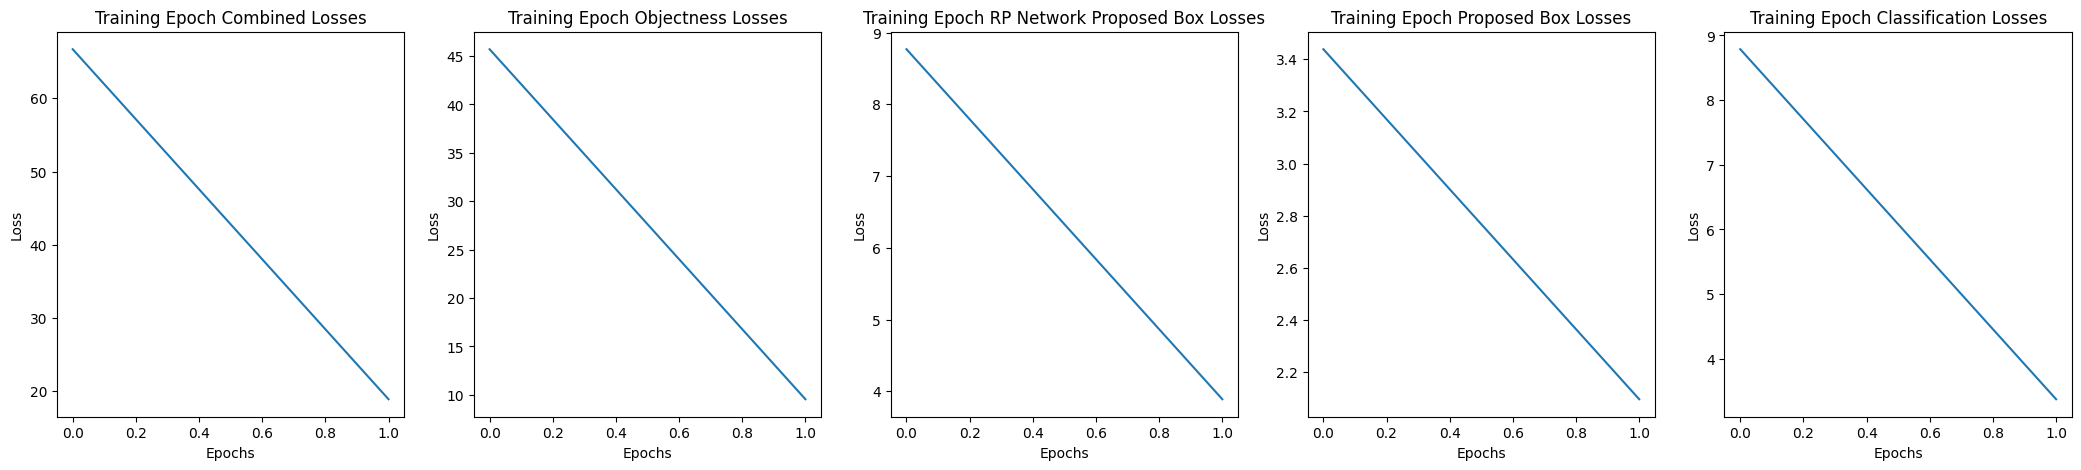

In [11]:
# Plot Baseline training and validation metrics
worker.plot_losses(True)
plt.show()

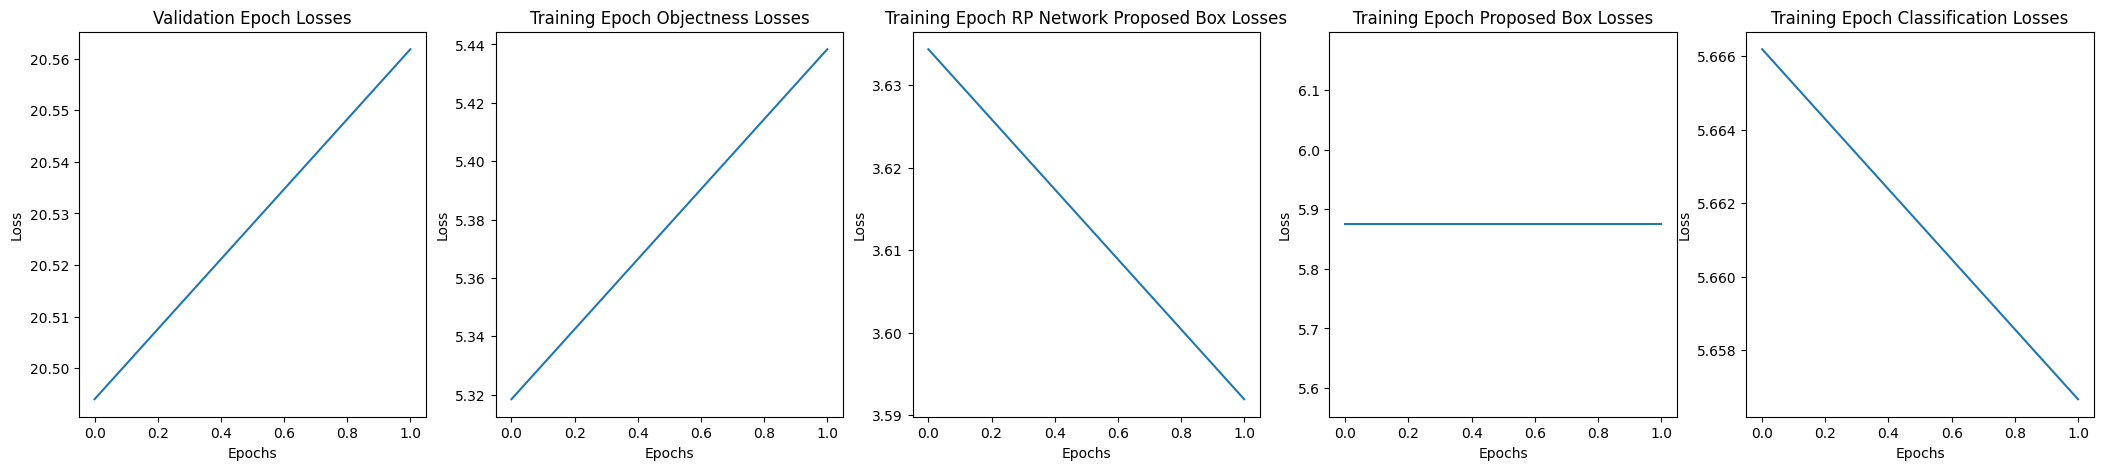

In [12]:
worker.plot_losses(False)
plt.show()

#### Section 4.1.4 - Baseline Testing

In [13]:
test_images = os.path.join(workspace_builder._data_path, "test")
test_annotations = os.path.join(workspace_builder._data_path, "annotations", "test_annotations.coco.json")
test_data = SeaSarFRCNN(test_images, test_annotations, transform=tester_transforms)
test_data = torchvision.datasets.wrap_dataset_for_transforms_v2(test_data, target_keys=("boxes", "labels"))
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, collate_fn=test_data._packager, num_workers=1)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
worker.model_test(test_dataloader, 0.0)

# Section 5 - Canny FRCNN

In this section, we utilize the OpenCV implementation of the Canny algorithm as a preprocessing layer to Faster-RCNN and analyze its performance.  Canny is a popular multi-stage edge detection algorithm designed to a) highlight the edges of all objects within an image and b) remove anything between different edges. 

In using this algorithm, we hypothesize that FRCNN will achieve better performance on more complex images since much of the noise of non-targets is removed and only the outline of the edges is considered.  By training on a ship's outline, which is relatively consistent regardless of ship sizes, we expect the model to identify targets in areas that previously had significant amounts of noise, such as docks, inclement weather, and other confusers.

## 5.1 - Canny Overview

The Canny pipeline includes three steps:

1. **Noise Reduction**: Use Gaussian Blurring on the entire image to reduce noise surrounding edges that may lead to false positives.
2. **Gradient Intensity**: It then uses the Sobel kernel (another Edge Detection method) in the X and Y directions to determine the gradient magnitude. Then it uses a formula to extract the gradient direction of individual pixels.
3. **Non-Maximum Suppression**: Once edges are proposed, NMS is used to remove any pixels that may be a false positive edge.

For more details on the Canny algorithm, OpenCV's documentation has a good explanation of the topic: https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

## 5.2 - Data Analysis

Below, we provide an example of how Canny can assist the detection models by remove noise and highlight ship outlines.  In the original image, targets are intermingled with what appears to be either inclement weather or some other noise type.  In the succeeding subplot, we can see those inclement weather spots are fully removed while the outline of the targets are retained.

In [15]:
examples_dataset = SeaSarFRCNN(train_images, train_annotations)

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


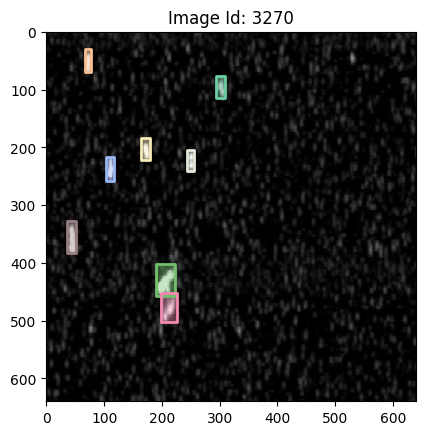

In [16]:
image, target = examples_dataset._get_image(3270, True, True)

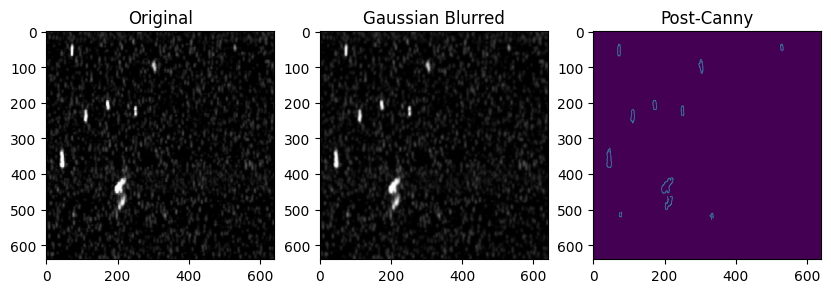

In [17]:
gaussian_image = cv2.GaussianBlur(np.array(image), ksize=(5, 5), sigmaX=2.0)
canny_image = cv2.Canny(gaussian_image, 200, 100)
examples_dataset.show_edited_subplot([image, gaussian_image, canny_image], ["Original", "Gaussian Blurred", "Post-Canny"], "", "")

### 5.2.1 - False Positives

As shown in 5.3, setting the Canny thresholds to (200, 100) began yield positive results like the image above.  However, there are some drawbacks to using static threshold values. Setting the threshold too high can remove key target details or even entire targets. Using a value too small will not remove enough noise and can reduce model performance.  As we see in the below figures, (200, 100) is not a high enough threshold to clear much of the noise from the shoreline, inevitably leading to misclassifications.

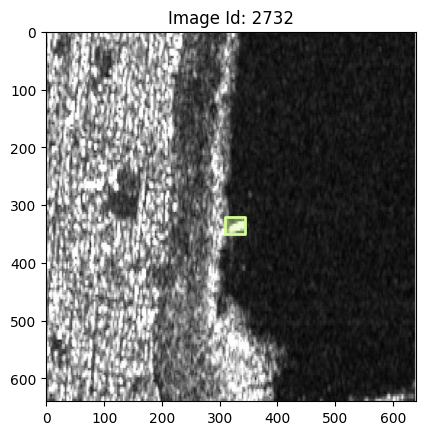

In [18]:
image, target = examples_dataset._get_image(2732, get_image=True)

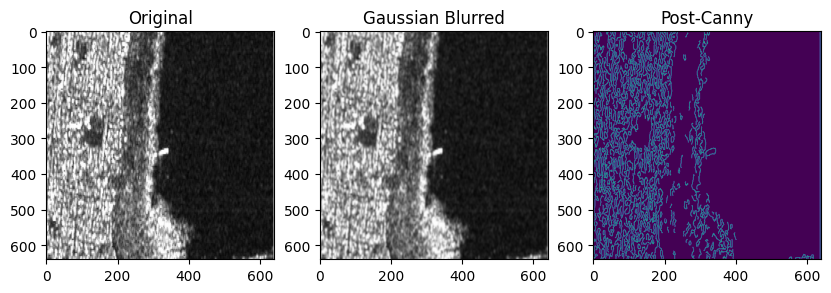

In [19]:
gaussian_image = cv2.GaussianBlur(np.array(image), ksize=(5, 5), sigmaX=2.0)
canny_image = cv2.Canny(gaussian_image, 200, 100)
examples_dataset.show_edited_subplot([image, gaussian_image, canny_image], ["Original", "Gaussian Blurred", "Post-Canny"], "", "")

## Section 5.3 Model Construction and Training

In this section, we build the CannyFRCNN model.  We use a 3x3 kernel and standard deviation of 1 for Gaussian Blurring. For Canny, using 200 or higher for threshold 1 and 100 or higher for threshold 2 began to show good results on most images as this is when noise began being filtered out. 

In [20]:
canny_model = CannyFRCNN(frcnn, 'cuda', (3, 3), 1.0, 200, 100)
worker = ModelWorkerFRCNN(optimizer, canny_model, False)

In [ ]:
worker.train(train_dataloader, num_epochs=1, indices_to_skip=[3736])

# Section 6 - Robinson Compass FRCNN

This section uses the Robinson Compass edge detection algorithm in the same manner as the aforementioned Canny Algorithm.  The algorithm seeks to highlight target edges based on some threshold using eight different kernels highlighting edges based on the eight primary compass directions.  We anticipate comparable results to the Canny method since RC will consider edges from eight different directions across a gradient image rather than the approach Canny takes. 

## 6.1 - Robinson Compass Overview

Robinson Compass relies on using kernels that highlight edges focused on a specified direction using Compass directions to select them.  There are eight kernels corresponding to eight compass directions.

The Robinson Compass implementation was inspired from the following link: https://medium.com/@erhan_arslan/exploring-edge-detection-in-python-3-compass-edge-detector-edf8721a7825

In [22]:
rob_comp = RobinsonCompass((3, 3), 1, 500)

## 6.2 - Data Overview

Below, we can see that some images are easier to extract primary targets.  The target edges are thick and resemble blobs more, likely making it easier for the FRCNN model to detect them.

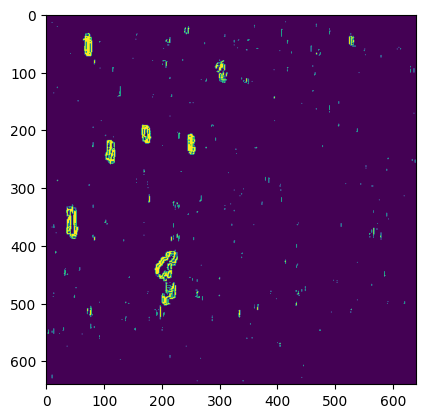

In [23]:
image, target = examples_dataset._get_image(3270, True, False)
image = np.array(image)
edges = rob_comp.get_detections(image)
plt.imshow(edges)

### 6.2.1 - False Positives

Like the Canny method, the compass method also suffers from the thresholding issue.  Below the same image shows even more false edges in the image.  This in turn may prove our original hypothesis wrong about RC since there will be far more confuser information present.

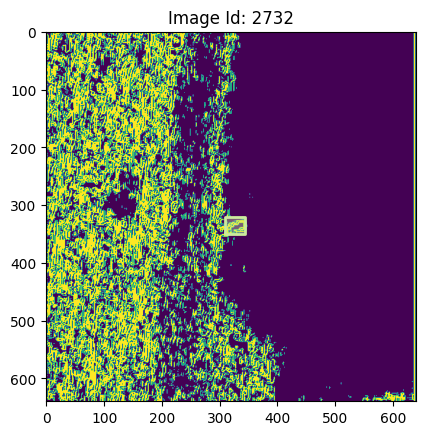

In [24]:
image, target = examples_dataset._get_image(2732, get_image=True)
image = np.array(image)
edges = rob_comp.get_detections(image)
plt.imshow(edges)

## 6.3 - Model Construction and Training

In [25]:
rob_comp_model = RobinsonFRCNN(frcnn, 'cuda', (3, 3), 1, 500)
worker = ModelWorkerFRCNN(optimizer, rob_comp_model, False)

In [ ]:
worker.train(train_dataloader, num_epochs=1, indices_to_skip=[3736])